## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [3]:
val_dataset = ArgoverseDataset(city = city, split = 'val')

In [4]:
len(val_dataset)

2399

## Create a DataLoader class for training

In [5]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [6]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [7]:
pred = Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

In [9]:
for epoch in range(100):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

epoch 0 loss: 380084.35665384395
epoch 1 loss: 362147.8741190479
epoch 2 loss: 330976.7309799203
epoch 3 loss: 318837.74728825135
epoch 4 loss: 293762.63018563384
epoch 5 loss: 276665.68182098796
epoch 6 loss: 279099.96090108465
epoch 7 loss: 264577.7583283546
epoch 8 loss: 253173.51524546143
epoch 9 loss: 236803.1520662675
epoch 10 loss: 226774.93254397958
epoch 11 loss: 223561.01672311084
epoch 12 loss: 230691.70616409404
epoch 13 loss: 216628.63605745908
epoch 14 loss: 194775.48904852237
epoch 15 loss: 215619.48243407963
epoch 16 loss: 187808.10729687137
epoch 17 loss: 197587.01937167978
epoch 18 loss: 196530.53910641297
epoch 19 loss: 171802.09166252127
epoch 20 loss: 189301.11568747292
epoch 21 loss: 177610.2464888276
epoch 22 loss: 179871.48778562128
epoch 23 loss: 176314.51634515094
epoch 24 loss: 164947.6889748319
epoch 25 loss: 166403.958102337
epoch 26 loss: 155779.4059226927
epoch 27 loss: 155827.97740115414
epoch 28 loss: 140066.44174000045
epoch 29 loss: 154509.16151156786

In [30]:
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    preds = pred(inp)
    loss = ((preds - out) ** 2).sum()

    val_loss += loss.item()
print('loss: {}'.format(val_loss / len(val_dataset)))

loss: 48721.0293654672


## Sample a batch of data and visualize 

torch.Size([4, 50, 2]) torch.Size([4, 60, 2])


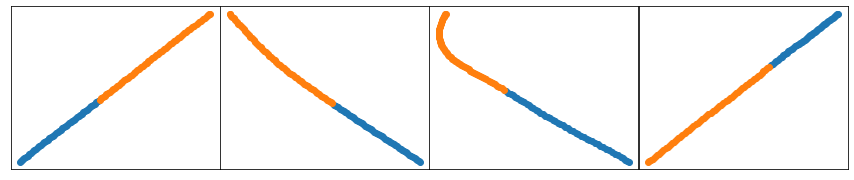

In [32]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape, out.shape)
    
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break